In [57]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import math
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import statsmodels.api as sm
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (12,9)

In [81]:
def load_hourly_fi_spotdata(): # hourly data
    dataframes = []
    rel_path = "data/elspot/"
    for excel in sorted(os.listdir(rel_path)):
        df = pd.read_excel(rel_path+excel,header=2,decimal=",",dtype={'FI': np.float64})
        dataframes.append(df)
    dataframes.pop()
    elspot_df = pd.concat(dataframes, ignore_index=True)
    fi_df = pd.DataFrame(pd.date_range(start='01/01/2013', end='01/01/2019',freq='H', tz='Europe/Berlin'), columns=['Date'])
    #fi_df = pd.DataFrame(pd.date_range(start='01/01/2013', end='29/01/2019',freq='H', tz='Europe/Berlin'), columns=['Date'])
    fi_df = fi_df[:-1] # poista turha 01/01/2019 date
    fi_df[['FI']] = elspot_df[['FI']]
    fi_df.set_index('Date',inplace=True)
    fi_df.fillna(method="bfill",inplace=True)
    return fi_df
def load_daily_fi_spotdata():
    dataframes = []
    rel_path = "data/elspot_daily/"
    for excel in sorted(os.listdir(rel_path)):
        df = pd.read_excel(rel_path+excel,header=2,decimal=",",dtype={'FI': np.float64})
        dataframes.append(df)
    elspot_df = pd.concat(dataframes,ignore_index=True)
    fi_df = pd.DataFrame(pd.date_range(start='01/01/2013', end='01/01/2019',freq='D'), columns=['Date'])
    fi_df[['FI']] = elspot_df[['FI']]
    fi_df.set_index('Date',inplace=True)
    fi_df.fillna(method="bfill",inplace=True)
    fi_df = fi_df[:-1] # poista turha 01/01/2019 date
    return fi_df
def load_future_spotdata():
    df = pd.read_excel('data/elspot/elspot-prices_2019_hourly_eur_updated.xlsx',header=2,decimal=",",dtype={'FI':np.float64})
    fi_df = pd.DataFrame(pd.date_range(start='01-01-2019', end='02-01-2019',freq='H'), columns=['Date'])[:-2]
    fi_df[['FI']] = df[['FI']]
    fi_df.set_index('Date',inplace=True)
    return fi_df
def load_hourly_fi_tempdata(): # hourly data
    df = pd.read_excel("data/lampotila/helsinki/helsinki_vantaa_2013-2018_lampotila_tunneittain.xlsx",sheet_name="Havainnot")
    helsinki_df = pd.DataFrame(pd.date_range(start="01/01/2013 00:00",end="01/01/2019 00:00",freq='H', tz='Europe/London'),columns=['Date'])
    helsinki_df['Temperature'] = df['Ilman lämpötila (degC)']
    helsinki_df.set_index('Date',inplace=True)
    helsinki_df.fillna(method="bfill",inplace=True)
    df = pd.read_excel("data/lampotila/jyvaskyla/jyvaskylan_lentoasema_2013-2018_lampotila_tunneittain.xlsx",sheet_name="Havainnot")
    jyvaskyla_df = pd.DataFrame(pd.date_range(start="01/01/2013 00:00",end="01/01/2019 00:00",freq='H', tz='Europe/London'),columns=['Date'])
    jyvaskyla_df['Temperature'] = df['Ilman lämpötila (degC)']
    jyvaskyla_df.set_index('Date',inplace=True)
    jyvaskyla_df.fillna(method="bfill",inplace=True)
    df = pd.read_excel("data/lampotila/rovaniemi/rovaniemi_lentoasema_2013-2018_lampotila_tunneittain.xlsx",sheet_name="Havainnot")
    rovaniemi_df = pd.DataFrame(pd.date_range(start="01/01/2013 00:00",end="01/01/2019 00:00",freq='H', tz='Europe/London'),columns=['Date'])
    rovaniemi_df['Temperature'] = df['Ilman lämpötila (degC)']
    rovaniemi_df.set_index('Date',inplace=True)
    rovaniemi_df.fillna(method="bfill",inplace=True)    
    return helsinki_df,jyvaskyla_df,rovaniemi_df
def load_emission_market_data(): # data from varying days
    data_df = pd.read_excel("data/eex_emissions_market/2013-emission-spot-primary-market-auction-report-data.xls",sheet_name="Primary Market Auction",header=2)
    return data_df
def load_energy_consumption_data(): #hourly data
    with open("data/kulutus/energy_consumption_finland_2013-2018.json",'r') as js:
        data = json.load(js)
    df = pd.DataFrame(data)    
    consumption_df = pd.DataFrame(pd.date_range(start="01/01/2013 00:00",end="01/01/2019 00:00",freq='H', tz='Europe/London'),columns=['Date'])
    consumption_df['Consumption'] = df['value']
    consumption_df.set_index('Date',inplace=True)
    return consumption_df
def load_nuclear_power_data(): # data is in 3 minute intervals
    with open("data/ydinvoima/nuclear_power_finland_2013-2018.json",'r') as js:
        data = json.load(js)
    df = pd.DataFrame(data=data)
    df = df.drop(columns=['end_time'])
    df['start_time'] = pd.to_datetime(df['start_time'])
    df.set_index('start_time',inplace=True)
    df = df.resample('H').mean().ffill() # ffill to prevent missing values
    return df
def load_wind_power_data():
    with open("data/tuulivoima/wind_power_production_finland_2013-2018.json",'r') as js:
        data = json.load(js)
    df = pd.DataFrame(data=data)
    df = df.drop(columns=['end_time'])
    df['start_time'] = pd.to_datetime(df['start_time'])
    df.set_index('start_time',inplace=True)
    df = df.resample('H').mean().ffill() # ffill to prevent missing values
    return df
def load_power_transfer_data(): # positive means that electricity was exported from FI to X and vice versa
    dataframes = [] #order = FI-EE, FI-NO, FI-RU, FI-SE1, FI-SE3
    rel_path = "data/sahkonsiirto/"
    for jsfile in sorted(os.listdir(rel_path)):
        with open(rel_path + jsfile,'r') as js:
            data = json.load(js)
            df = pd.DataFrame(data)    
            df.drop(columns=['end_time'],inplace=True)
            df['start_time'] = pd.to_datetime(df['start_time'])
            df.set_index('start_time',inplace=True)
            df = df[:-1]
            # cleaning up extra rows
            for timestamp in df.index:
                if timestamp.minute != 0:
                    df.drop(timestamp,inplace=True)
            dataframes.append(df)
    return dataframes
def load_hydro_reservoir_data(): # weekly data
    dataframes = []
    rel_path = 'data/hydro_reservoir/'
    for table in sorted(os.listdir(rel_path)):
        df = pd.read_html(rel_path + table)[0]
        df.columns = ['Week','NO','SE','FI']
        dataframes.append(df)
    dfs = pd.concat(dataframes, ignore_index=True)[:-2]
    all_df = pd.DataFrame(index=pd.date_range(start="01/01/2013 00:00",end="01/01/2019 00:00",freq='W-MON'),columns=['NO','SE','FI'])[:-1]
    # data cleaning
    df1 = dfs[:260]
    df2 = dfs[260:]
    df2.loc[259] = ["01 - 18","57311","21437","4008"] # missing one week of data at the beginning of 2018
    df2.loc[310] = ['52 - 18', '56906','18662','2774'] # missing one week at the end of 2018, 56906 is two weeks earlier value, because a replacement value was not found
    df2 = df2.sort_index()
    dfs = pd.concat([df1,df2],ignore_index=True)
    all_df['NO'], all_df['SE'], all_df['FI'] = dfs['NO'].values, dfs['SE'].values,dfs['FI'].values
    all_df = all_df.resample('H').pad() # CHANGE THIS TO INTERPOLATE
    start = all_df.index.min().date() + pd.Timedelta(-6,'D') # change start index to beginning of the year
    end = all_df.index.max().date() + pd.Timedelta(8,'D') # change end index to the end of the year
    all_df = all_df.reindex(pd.date_range(start,end,freq='H')).bfill().ffill()[:-2] # CHANGE THIS TO INTERPOLATE
    return all_df

/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


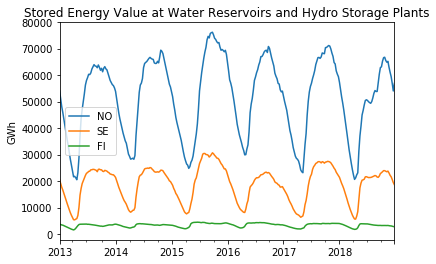

In [3]:
dataframes = []
rel_path = 'data/hydro_reservoir/'
for table in sorted(os.listdir(rel_path)):
    df = pd.read_html(rel_path + table)[0]
    df.columns = ['Week','NO','SE','FI']
    dataframes.append(df)
dfs = pd.concat(dataframes, ignore_index=True)[:-2]
all_df = pd.DataFrame(index=pd.date_range(start="01/01/2013 00:00",end="01/01/2019 00:00",freq='W-MON'),columns=['NO','SE','FI'])[:-1]
# data cleaning
df1 = dfs[:260]
df2 = dfs[260:]
df2.loc[259] = ["01 - 18","57311","21437","4008"] # missing one week of data at the beginning of 2018
df2.loc[310] = ['52 - 18', '56906','18662','2774'] # missing one week at the end of 2018, 56906 is two weeks earlier value, because a replacement value was not found
df2 = df2.sort_index()
dfs = pd.concat([df1,df2],ignore_index=True)
all_df['NO'], all_df['SE'], all_df['FI'] = dfs['NO'].values, dfs['SE'].values,dfs['FI'].values
all_df[all_df.columns] = all_df[all_df.columns].apply(pd.to_numeric)
ax = all_df.plot()
ax.set_ylabel("GWh")
ax.set_title("Stored Energy Value at Water Reservoirs and Hydro Storage Plants")
plt.show()
#all_df = all_df.resample('H').pad() # CHANGE THIS TO INTERPOLATE
#start = all_df.index.min().date() + pd.Timedelta(-6,'D') # change start index to beginning of the year
#end = all_df.index.max().date() + pd.Timedelta(8,'D') # change end index to the end of the year
#all_df = all_df.reindex(pd.date_range(start,end,freq='H')).bfill().ffill()[:-2] # CHANGE THIS TO INTERPOLATE

Power Exchange data has additional observations from the hourly frequency. The options are to remove the additional rows or calculate a mean for the hour. Code example to find values from the inconsistent hourly intervals.

```python
for month in range(1,13):
    date = f"2013-{month}"
    month_df = fi_ee_df[date]
    temp = month_df.groupby([month_df.index.day]).count()
    for x in temp['value']:
        if x != 24:
            print(f"problem in month {month}")
```

Null rows in Finland's wind power production and nuclear power production (after resampling) were found using the code below.
```python
index = combined_df['Nuclear Power Production FI'].index[combined_df['Nuclear Power Production FI'].apply(np.isnan)]
```

In [4]:
fi_spotdf = load_hourly_fi_spotdata()
helsinki_tempdf, jyvaskyla_tempdf, rovaniemi_tempdf = load_hourly_fi_tempdata()
consumption_tempdf = load_energy_consumption_data()
nuclear_tempdf = load_nuclear_power_data()
wind_power_tempdf = load_wind_power_data()
fi_ee_df, fi_no_df, fi_ru_df, fi_se1_df, fi_se3_df = load_power_transfer_data()
hydro_df = load_hydro_reservoir_data()

/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
spot_df = fi_spotdf
spot_df.index = spot_df.index.tz_convert('Europe/London')
spot_df = spot_df[1:]
helsinki_df, jyvaskyla_df, rovaniemi_df, consumption_df = helsinki_tempdf[:-2], jyvaskyla_tempdf[:-2], rovaniemi_tempdf[:-2], consumption_tempdf[:-2]
nuclear_fi_df = nuclear_tempdf[:-1]
wind_power_df = wind_power_tempdf

/home/joni/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


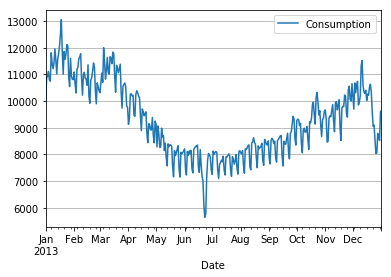

In [6]:
lol_df = consumption_df['2013'].resample('D').mean()# ffill to prevent missing values
ax = lol_df.plot()
ax.yaxis.grid()
plt.show()

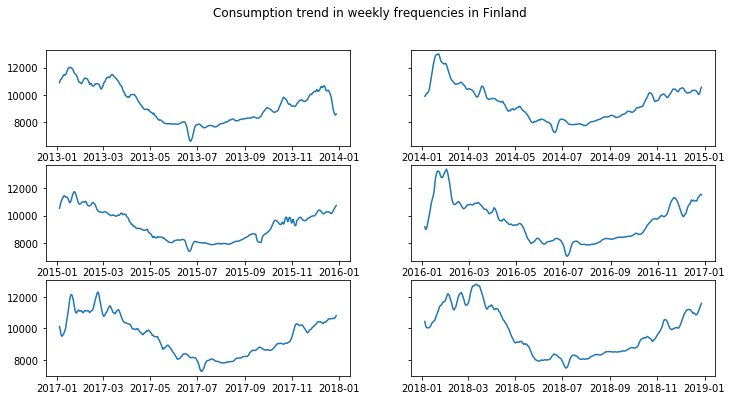

In [7]:
trends_consumption = []
for year in sorted(set(consumption_df.index.year)):
    decomposition = sm.tsa.seasonal_decompose(consumption_df[f"{year}"].resample('D').mean(), freq=7, model='additive')
    trend = decomposition.trend
    trends_consumption.append(trend)
fig, ax = plt.subplots(3,2,sharey='row',figsize=(12,6))
fig.suptitle('Consumption trend in weekly frequencies in Finland')
x = 0
for i in range(0,3):
    for j in range(0,2):
        ax[i,j].plot(trends_consumption[x])
        x+=1
plt.show()

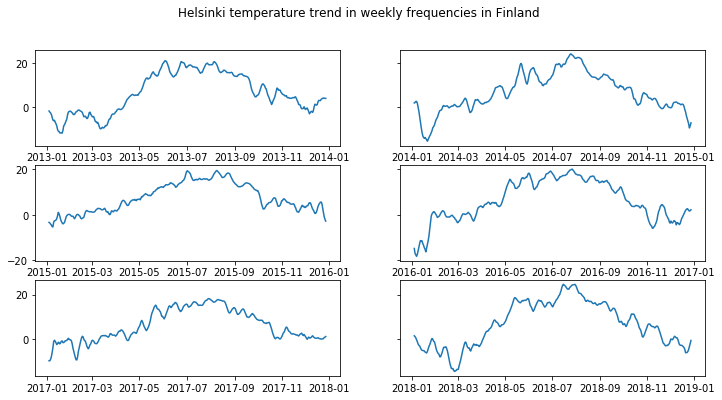

In [8]:
trends = []
for year in sorted(set(consumption_df.index.year)):
    decomposition = sm.tsa.seasonal_decompose(helsinki_df[f"{year}"].resample('D').mean(), freq=7, model='additive')
    trend = decomposition.trend
    trends.append(trend)
fig, ax = plt.subplots(3,2,sharey='row',figsize=(12,6))
fig.suptitle('Helsinki temperature trend in weekly frequencies in Finland')
x = 0
for i in range(0,3):
    for j in range(0,2):
        ax[i,j].plot(trends[x])
        x+=1

In [9]:
"""
resids = []
for year in sorted(set(consumption_df.index.year)):
    decomposition = sm.tsa.seasonal_decompose(consumption_df[f"{year}"].resample('D').mean(), freq=7, model='additive')
    resid = decomposition.resid
    resids.append(resid)
fig, ax = plt.subplots(3,2,sharey='row',figsize=(12,6))
x = 0
for i in range(0,3):
    for j in range(0,2):
        ax[i,j].plot(resids[x])
        x+=1"""

'\nresids = []\nfor year in sorted(set(consumption_df.index.year)):\n    decomposition = sm.tsa.seasonal_decompose(consumption_df[f"{year}"].resample(\'D\').mean(), freq=7, model=\'additive\')\n    resid = decomposition.resid\n    resids.append(resid)\nfig, ax = plt.subplots(3,2,sharey=\'row\',figsize=(12,6))\nx = 0\nfor i in range(0,3):\n    for j in range(0,2):\n        ax[i,j].plot(resids[x])\n        x+=1'

In [26]:
combined_df = pd.DataFrame(index=pd.date_range(start="01/01/2013 00:00",end="01/01/2019 00:00",freq='H'))
combined_df = combined_df[:-2]
combined_df['Spot'] = spot_df.values[:,0]
combined_df['Helsinki Temperature'] = helsinki_df.values[:,0]
combined_df['Jyvaskyla Temperature'] = jyvaskyla_df.values[:,0]
combined_df['Rovaniemi Temperature'] = rovaniemi_df.values[:,0]
combined_df['Consumption'] = consumption_df.values[:,0]
combined_df['Nuclear Power Production FI'] = nuclear_fi_df.values[:,0]
combined_df['Wind Power Production FI'] = wind_power_df.values[:,0]
combined_df['FI-EE'], combined_df['FI-NO'], combined_df['FI-RU'], combined_df['FI-SE1'], combined_df['FI-SE3'] = fi_ee_df.values[:,0], fi_no_df.values[:,0], fi_ru_df.values[:,0], fi_se1_df.values[:,0], fi_se3_df.values[:,0]
combined_df['Hydro Reservoir NO'], combined_df['Hydro Reservoir SE'], combined_df['Hydro Reservoir FI'] = hydro_df['NO'].values, hydro_df['SE'].values, hydro_df['FI'].values
combined_df

,Spot,Helsinki Temperature,Jyvaskyla Temperature,Rovaniemi Temperature,Consumption,Nuclear Power Production FI,Wind Power Production FI,FI-EE,FI-NO,FI-RU,FI-SE1,FI-SE3,Hydro Reservoir NO,Hydro Reservoir SE,Hydro Reservoir FI
2013-01-01 00:00:00,27.51,1.2,0.6,-0.6,9494.0,2773.600,47.6500,365.700,0.300,-1361.931,-634.040,-821.420,54099,20521,3793
2013-01-01 01:00:00,24.44,1.1,0.6,-0.7,9265.0,2772.800,49.9000,312.100,0.200,-1362.781,-447.700,-821.460,54099,20521,3793
2013-01-01 02:00:00,21.81,1.4,0.6,-0.9,9161.0,2773.800,51.3000,291.200,0.300,-1362.837,-368.840,-821.420,54099,20521,3793
2013-01-01 03:00:00,22.37,1.9,0.4,-1.1,9240.0,2773.550,53.5000,304.600,0.300,-1388.315,-412.460,-812.600,54099,20521,3793
2013-01-01 04:00:00,25.51,2.5,0.3,-1.2,9419.0,2773.750,53.7500,327.400,0.200,-1384.397,-513.030,-821.790,54099,20521,3793
2013-01-01 05:00:00,27.93,2.8,0.5,-1.4,9400.0,2773.400,52.2000,362.400,0.300,-1374.759,-340.420,-821.580,54099,20521,3793
2013-01-01 06:00:00,28.01,2.8,0.4,-1.3,9554.0,2773.150,52.6500,365.800,0.300,-1402.746,-270.780,-821.900,54099,20521,3793
2013-01-01 07:00:00,27.80,2.9,0.4,-1.4,9524.0,2773.550,55.1500,365.700,0.200,-1387.554,-211.580,-821.630,54099,20521,3793
2013-01-01 08:00:00,27.35,2.9,0.2,-1.2,9593.0,2773.350,53.5000,365.800,0.300,-1384.241,-226.000,-821.740,54099,20521,3793
2013-01-01 09:00:00,28.22,2.9,0.1,-0.9,9778.0,2773.550,56.5500,365.800,0.300,-1402.657,-241.210,-821.720,54099,20521,3793


# Facebook Prophet
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.https://github.com/facebook/prophet


Creating and fitting a model with Facebook Prophet, then predicting January 2019 spot prices with the model.

In [129]:
import fbprophet
spot = pd.DataFrame(columns=['ds','y'])
spot['y'] = combined_df['Spot']
spot['ds'] = combined_df.index
spot.index = pd.RangeIndex(len(spot.index))
scales = [0.001,0.005,0.01,0.05,0.1,0.5]
forecasts = []
for scale in scales:
    prophet = fbprophet.Prophet(changepoint_prior_scale=scale)
    prophet.fit(spot)
    forecast = prophet.make_future_dataframe(periods=31*24,freq='H')
    forecast = prophet.predict(forecast)
    forecast.set_index(['ds'],inplace=True)
    forecasts.append(forecast)

/home/joni/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


To determine which changepoint prior scale fits our data best, we compare forecasted values to actual spot prices and calculate error with RMSE(Root mean squared error). The best result was with changepoint_prior_scale 0.05. Changepoint scaling adjusts the flexibility of the trend. The higher the value, the more flexible the trend will be.

In [130]:
future_df = load_future_spotdata()
print(f"Changepoint Prior Scale 0.001 Root Mean Squared Error: {np.sqrt(mean_squared_error(future_df.values,forecasts[0]['2019-01-01':][['yhat']].values))}")
print(f"Changepoint Prior Scale 0.005 Root Mean Squared Error: {np.sqrt(mean_squared_error(future_df.values,forecasts[1]['2019-01-01':][['yhat']].values))}")
print(f"Changepoint Prior Scale 0.01 Root Mean Squared Error: {np.sqrt(mean_squared_error(future_df.values,forecasts[2]['2019-01-01':][['yhat']].values))}")
print(f"Changepoint Prior Scale 0.05 Root Mean Squared Error: {np.sqrt(mean_squared_error(future_df.values,forecasts[3]['2019-01-01':][['yhat']].values))}")
print(f"Changepoint Prior Scale 0.1 Root Mean Squared Error: {np.sqrt(mean_squared_error(future_df.values,forecasts[4]['2019-01-01':][['yhat']].values))}")
print(f"Changepoint Prior Scale 0.5 Root Mean Squared Error: {np.sqrt(mean_squared_error(future_df.values,forecasts[5]['2019-01-01':][['yhat']].values))}")

Changepoint Prior Scale 0.001 Root Mean Squared Error: 10.45723098462977
Changepoint Prior Scale 0.005 Root Mean Squared Error: 10.489391830654109
Changepoint Prior Scale 0.01 Root Mean Squared Error: 10.5268459236213
Changepoint Prior Scale 0.05 Root Mean Squared Error: 10.428474775656095
Changepoint Prior Scale 0.1 Root Mean Squared Error: 10.490271895931325
Changepoint Prior Scale 0.5 Root Mean Squared Error: 10.51774922280185


In [203]:
#fig, ax = plt.subplots(1,1,figsize=(12,6))
forecasts[3]['2018'][['yearly']].plot(subplots=True,figsize=(10,4))
plt.title('Yearly Spot price seasonality')
plt.show()

days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
forecasts[3]['2018-01-01':'2018-01-07'][['weekly']].plot(subplots=True,figsize=(10,4))
plt.xticks(days)
plt.title('Weekly Spot price seasonality')
plt.show()

forecasts[3]['2018-01-01':'2018-01-02'][['daily']].plot(subplots=True,figsize=(10,4))
plt.title('Daily Spot price seasonality')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DateParseError: Unable to parse datetime string: MON

How the forecasts look compared to forecasted values in a line graph

<IPython.core.display.Javascript object>


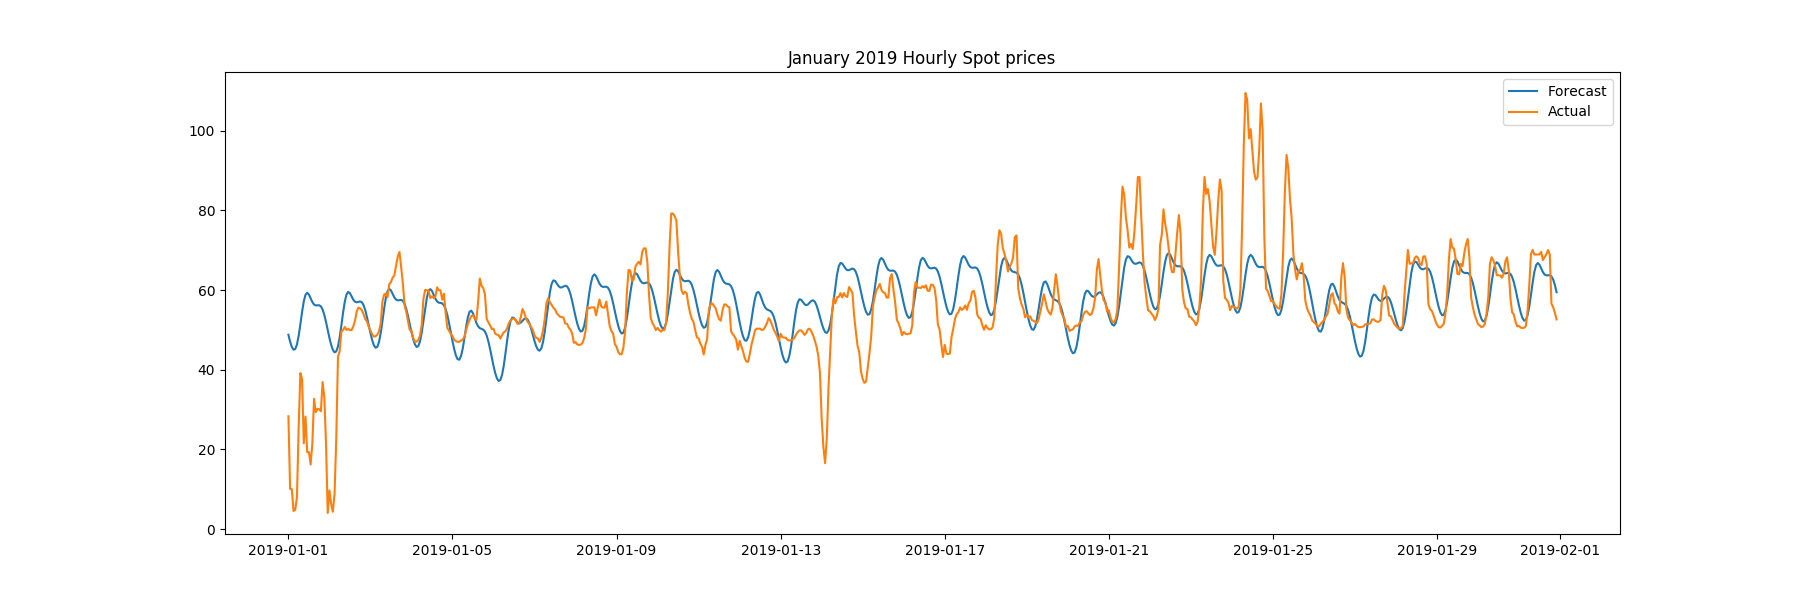

Text(0.5, 1.0, 'January 2019 Hourly Spot prices')

In [194]:
plt.subplots(figsize=(18,6))
plt.plot(forecasts[3]['2019-01-01':'2019-01-31'][['yhat']],label='Forecast')
plt.plot(future_df['2019-01-01':'2019-01-31'],label='Actual')
plt.legend()
plt.title('January 2019 Hourly Spot prices')

In [13]:
sch_df = combined_df[['FI-SE1','FI-SE3','FI-RU']].resample('D').mean()
spot_daily_df = load_daily_fi_spotdata()
sch_df['Spot Daily'] = spot_daily_df.values[:,0]
sch_df

/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,FI-SE1,FI-SE3,FI-RU,Spot Daily
2013-01-01,-332.383917,-784.910417,-1402.108750,30.44
2013-01-02,-857.876667,-765.014167,-1445.654000,37.09
2013-01-03,-961.168750,-753.927500,-1454.270417,35.03
2013-01-04,-1025.685833,-789.931250,-1453.928292,34.53
2013-01-05,-640.896333,-643.465417,-1460.942500,35.45
2013-01-06,-540.124000,-669.091250,-1448.974125,34.84
2013-01-07,-1097.498750,-713.342917,-1450.412333,39.34
2013-01-08,-776.331708,-650.349167,-1452.726000,40.09
2013-01-09,-654.848792,-630.488333,-1041.042708,39.76
2013-01-10,-761.585750,-404.881167,-1054.417250,41.09


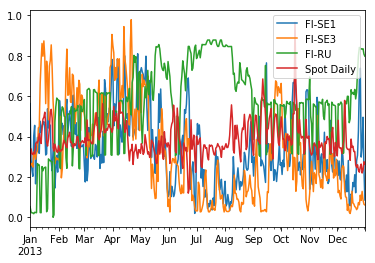

In [14]:
normalized_df = sch_df
scaled_values = preprocessing.MinMaxScaler().fit_transform(sch_df)
normalized_df.loc[:,:] = scaled_values
normalized_df['2013'].resample('D').mean().plot()

In [15]:
normalized_df = combined_df
normalized_values = preprocessing.MinMaxScaler().fit_transform(combined_df)
normalized_df.loc[:,:] = normalized_values # normalized data
normalized_df.tail(10)

/home/joni/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Spot,Helsinki Temperature,Jyvaskyla Temperature,Rovaniemi Temperature,Consumption,Nuclear Power Production FI,Wind Power Production FI,FI-EE,FI-NO,FI-RU,FI-SE1,FI-SE3,Hydro Reservoir NO,Hydro Reservoir SE,Hydro Reservoir FI
2018-12-31 13:00:00,0.194032,0.454237,0.384494,0.442464,0.652355,0.998090,0.886192,0.695337,0.892807,0.043121,0.171090,0.609786,0.653472,0.52454,0.403774
2018-12-31 14:00:00,0.195289,0.457627,0.401899,0.455429,0.605354,0.998128,0.923421,0.601659,0.864701,0.044709,0.163013,0.660660,0.653472,0.52454,0.403774
2018-12-31 15:00:00,0.198037,0.450847,0.417722,0.444084,0.569757,0.997976,0.940688,0.670335,0.838969,0.036059,0.253347,0.647634,0.653472,0.52454,0.403774
2018-12-31 16:00:00,0.198390,0.455932,0.433544,0.437601,0.545662,0.998533,0.936393,0.713092,0.850374,0.043157,0.334352,0.548444,0.653472,0.52454,0.403774
2018-12-31 17:00:00,0.195406,0.455932,0.446203,0.427877,0.534755,0.998333,0.945461,0.681818,0.813055,0.043255,0.236151,0.644322,0.653472,0.52454,0.403774
2018-12-31 18:00:00,0.194935,0.464407,0.455696,0.431118,0.543381,0.998242,0.950908,0.735455,0.807884,0.044988,0.275021,0.602919,0.653472,0.52454,0.403774
2018-12-31 19:00:00,0.194896,0.469492,0.462025,0.435981,0.585226,0.998052,0.924738,0.690309,0.779479,0.045749,0.439984,0.474515,0.653472,0.52454,0.403774
2018-12-31 20:00:00,0.197055,0.472881,0.471519,0.434360,0.671393,0.998292,0.921849,0.536414,0.791789,0.044479,0.624381,0.122546,0.653472,0.52454,0.403774
2018-12-31 21:00:00,0.198312,0.471186,0.479430,0.429498,0.713337,0.998457,0.897984,0.539536,0.701894,0.045826,0.617103,0.022505,0.653472,0.52454,0.403774
2018-12-31 22:00:00,0.195485,0.471186,0.484177,0.424635,0.736143,0.998356,0.872727,0.505317,0.655154,0.059813,0.604343,0.127846,0.653472,0.52454,0.403774


Nyt luotuna ns. multivariate aikasarja. Vector Auto Regression (VAR) malli voi ymmärtää eri muuttujien väliset suhteet ja käyttää niitä ennustamaan tulevaisuuden arvo. Alla Dickey Fullerin tapainen testi, mutta monelle muuttujalle eli Johansenin testi

In [16]:
johansen_test = coint_johansen(combined_df,-1,1)
print(f"Johansen test eigenvalues: {johansen_test.eig} \n Trace Statistics: {johansen_test.lr1}")

/home/joni/.local/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/vecm.py:609: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  category=HypothesisTestWarning)


Johansen test eigenvalues: [1.07817066e-01 9.17495185e-02 6.78588753e-02 6.54096841e-02
 4.93968525e-02 4.09944282e-02 3.27109317e-02 2.42654126e-02
 1.39795147e-02 1.12360778e-02 5.61824673e-03 1.97734463e-03
 9.75587029e-04 2.69253092e-04 2.08536555e-05] 
 Trace Statistics: [2.80169558e+04 2.20183005e+04 1.69581639e+04 1.32632416e+04
 9.70629415e+03 7.04261411e+03 4.84165789e+03 3.09292451e+03
 1.80128966e+03 1.06104654e+03 4.66898092e+02 1.70652088e+02
 6.65784010e+01 1.52560206e+01 1.09651749e+00]


In [17]:
train = combined_df['2013-01-01':'2017-12-31']
validation = combined_df['2018-01-01':'2018-12-31']
model = VAR(endog=train)
model = model.fit()
prediction = model.forecast(model.y, steps=len(validation))


pred = pd.DataFrame(index=range(0,len(prediction)),columns=[combined_df.columns])
for j in range(0,12):
    for i in range(0,len(prediction)):
        pred.iloc[i][j] = prediction[i][j]
for i in combined_df.columns:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], validation[i])))

rmse value for Spot is :  0.07736190277132768
rmse value for Helsinki Temperature is :  0.1828163580284121
rmse value for Jyvaskyla Temperature is :  0.18185739240092952
rmse value for Rovaniemi Temperature is :  0.18512867656625684
rmse value for Consumption is :  0.16579679153496282
rmse value for Nuclear Power Production FI is :  0.18616306260836324
rmse value for Wind Power Production FI is :  0.3204258710267581
rmse value for FI-EE is :  0.21253751169125815
rmse value for FI-NO is :  0.1555743742416289
rmse value for FI-RU is :  0.3131990767855912
rmse value for FI-SE1 is :  0.21855979418856994
rmse value for FI-SE3 is :  0.20550271771537115


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').